# Tech Challenge FIAP - Etapa 5: Treinamento e Avaliação

In [1]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('seaborn-v0_8')
np.random.seed(42)

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 1. Carregamento do Dataset

In [2]:
dataset_path = r"C:\Users\prado\.cache\kagglehub\datasets\awaiskaggler\insurance-csv\versions\1\insurance_preprocessed.csv"

try:
    df = pd.read_csv(dataset_path)
    print("Dataset carregado com sucesso!")
    print(f"Colunas: {list(df.columns)}")
    print("\nPrimeiras 5 linhas do dataset:")
    display(df.head())
    print("\nInformações do dataset:")
    display(df.info())
except FileNotFoundError:
    print("Arquivo não encontrado. Verifique o caminho do dataset.")
    print("Caminho esperado:", dataset_path)

Dataset carregado com sucesso!
Colunas: ['age', 'bmi', 'children', 'expenses', 'log_expenses', 'smoker_encoded', 'sex_male', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'age_bmi_interaction', 'age_squared', 'bmi_normal', 'bmi_obese', 'bmi_overweight', 'bmi_underweight', 'high_risk']

Primeiras 5 linhas do dataset:


,age,bmi,children,expenses,log_expenses,smoker_encoded,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,age_bmi_interaction,age_squared,bmi_normal,bmi_obese,bmi_overweight,bmi_underweight,high_risk
0,-1.440418,-0.453484,-0.909234,16884.92,9.734235,1,0,False,False,False,True,-1.305601,-1.221599,False,False,True,False,0
1,-1.511647,0.513986,-0.079442,1725.55,7.453880,0,1,False,False,True,False,-1.155713,-1.254484,False,True,False,False,0
2,-0.799350,0.382803,1.580143,4449.46,8.400763,0,1,False,False,True,False,-0.551569,-0.845647,False,True,False,False,0
3,-0.443201,-1.306169,-0.909234,21984.47,9.998137,0,1,False,True,False,False,-0.886375,-0.574570,True,False,False,False,0
4,-0.514431,-0.289506,-0.909234,3866.86,8.260457,0,1,False,True,False,False,-0.550037,-0.632340,False,False,True,False,0



Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1337 non-null   float64
 1   bmi                  1337 non-null   float64
 2   children             1337 non-null   float64
 3   expenses             1337 non-null   float64
 4   log_expenses         1337 non-null   float64
 5   smoker_encoded       1337 non-null   int64  
 6   sex_male             1337 non-null   int64  
 7   region_northeast     1337 non-null   bool   
 8   region_northwest     1337 non-null   bool   
 9   region_southeast     1337 non-null   bool   
 10  region_southwest     1337 non-null   bool   
 11  age_bmi_interaction  1337 non-null   float64
 12  age_squared          1337 non-null   float64
 13  bmi_normal           1337 non-null   bool   
 14  bmi_obese            1337 non-null   bool   
 15  bmi_overweigh

None

### 1.1. Correção do Data Leakage

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Colunas numéricas a ser normalizadas
numeric_cols = ['age', 'bmi', 'children']

features = df.drop(columns=['expenses', 'log_expenses'])
target_expenses = df['expenses']
target_log = df['log_expenses']

X_train, X_test, y_train_exp, y_test_exp, y_train_log, y_test_log = train_test_split(
    features, target_expenses, target_log, test_size=0.2, random_state=42, stratify=df['smoker_encoded']
)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

train_df = X_train_scaled.copy()
train_df['expenses'] = y_train_exp
train_df['log_expenses'] = y_train_log

test_df = X_test_scaled.copy()
test_df['expenses'] = y_test_exp
test_df['log_expenses'] = y_test_log

print("Normalização feita corretamente após o split. Exemplos dos dados normalizados (treino):")
display(train_df.head())

Normalização feita corretamente após o split. Exemplos dos dados normalizados (treino):


,age,bmi,children,smoker_encoded,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,age_bmi_interaction,age_squared,bmi_normal,bmi_obese,bmi_overweight,bmi_underweight,high_risk,expenses,log_expenses
367,0.209157,-0.957778,0.769598,0,0,False,True,False,False,-0.310370,0.025355,False,False,True,False,0,8017.06,8.989452
418,1.775700,1.376585,-0.076801,0,1,False,False,True,False,2.482171,2.097984,False,True,False,False,0,14418.28,9.576321
938,0.992428,-0.218015,-0.923201,0,1,False,False,True,False,0.672609,0.954127,False,False,True,False,0,9487.64,9.157851
533,-0.146876,0.883410,-0.923201,0,1,False,False,True,False,0.243620,-0.325712,False,True,False,False,0,19214.71,9.863483
354,-1.499800,1.228633,-0.923201,0,0,False,False,True,False,-1.000657,-1.254484,False,True,False,False,0,14133.04,9.556341


## 2. Pipeline de Modelagem para Múltiplos Targets

In [ ]:
# Função para preparar dados, treinar modelos, realizar validação cruzada e avaliar métricas
def run_regression_pipeline(df, target_column, drop_columns, model_names=None, revert_log=False):
    """
    Executa o pipeline de regressão para um target específico.
    - df: DataFrame de entrada
    - target_column: nome da coluna target
    - drop_columns: lista de colunas a remover das features (inclui o outro target)
    - model_names: nomes dos modelos para exibição
    - revert_log: se True, reverte np.expm1() nas métricas e previsões
    Retorna: dicionário com resultados, previsões, resíduos, etc.
    """
    X = df.drop(columns=drop_columns + [target_column] if target_column not in drop_columns else drop_columns)
    y = df[target_column]

    stratify_col = df['smoker_encoded']

    X_train, X_test, y_train, y_test, strat_train, strat_test = train_test_split(
        X, y, stratify_col, test_size=0.2, random_state=42, stratify=stratify_col
    )

    print("Proporção de classes em treino:")
    print(pd.Series(strat_train).value_counts(normalize=True))
    print("Proporção de classes em teste:")
    print(pd.Series(strat_test).value_counts(normalize=True))

    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    }
    if model_names:
        models = dict(zip(model_names, models.values()))

    predictions = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions[name] = model.predict(X_test)

    cv_folds = 5
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_results = {}
    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
        cv_rmse = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
        cv_results[name] = {
            'R2_scores': cv_scores,
            'R2_mean': cv_scores.mean(),
            'R2_std': cv_scores.std(),
            'RMSE_scores': cv_rmse,
            'RMSE_mean': cv_rmse.mean(),
            'RMSE_std': cv_rmse.std()
        }

    def calculate_metrics(y_true, y_pred):
        if revert_log:
            y_true = np.expm1(y_true)
            y_pred = np.expm1(y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}

    results = []
    for name in models.keys():
        metrics = calculate_metrics(y_test, predictions[name])
        metrics['Modelo'] = name
        results.append(metrics)
    results_df = pd.DataFrame(results)

    best_model_idx = results_df['R²'].idxmax()
    best_model_name = results_df.loc[best_model_idx, 'Modelo']
    best_predictions = predictions[best_model_name]
    if revert_log:
        residuals = np.expm1(y_test) - np.expm1(best_predictions)
    else:
        residuals = y_test - best_predictions

    return {
        'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test,
        'models': models, 'predictions': predictions, 'cv_results': cv_results,
        'results_df': results_df, 'best_model_name': best_model_name,
        'best_predictions': best_predictions, 'residuals': residuals,
        'cv_summary': pd.DataFrame({
            'Modelo': list(cv_results.keys()),
            'R² Médio': [cv_results[name]['R2_mean'] for name in cv_results.keys()],
            'R² Desvio': [cv_results[name]['R2_std'] for name in cv_results.keys()],
            'RMSE Médio': [cv_results[name]['RMSE_mean'] for name in cv_results.keys()],
            'RMSE Desvio': [cv_results[name]['RMSE_std'] for name in cv_results.keys()]
        }),
        'revert_log': revert_log
    }

## 3. Modelagem para ambos os targets

Pipeline para:
- Target 1: **expenses** (valor original)
- Target 2: **log_expenses** (transformação logarítmica)

In [5]:
print("=== Pipeline para target: expenses ===")
pipeline_expenses = run_regression_pipeline(
    pd.concat([train_df, test_df], ignore_index=True),
    target_column='expenses',
    drop_columns=['log_expenses'],
    model_names=None,
    revert_log=False
)
print("Concluído para expenses.\n")

print("=== Pipeline para target: log_expenses ===")
pipeline_log = run_regression_pipeline(
    pd.concat([train_df, test_df], ignore_index=True),
    target_column='log_expenses',
    drop_columns=['expenses'],
    model_names=None,
    revert_log=True
)
print("Concluído para log_expenses.")

=== Pipeline para target: expenses ===
Proporção de classes em treino:
smoker_encoded
0    0.795136
1    0.204864
Name: proportion, dtype: float64
Proporção de classes em teste:
smoker_encoded
0    0.794776
1    0.205224
Name: proportion, dtype: float64
Concluído para expenses.

=== Pipeline para target: log_expenses ===
Proporção de classes em treino:
smoker_encoded
0    0.795136
1    0.204864
Name: proportion, dtype: float64
Proporção de classes em teste:
smoker_encoded
0    0.794776
1    0.205224
Name: proportion, dtype: float64
Concluído para expenses.

=== Pipeline para target: log_expenses ===
Proporção de classes em treino:
smoker_encoded
0    0.795136
1    0.204864
Name: proportion, dtype: float64
Proporção de classes em teste:
smoker_encoded
0    0.794776
1    0.205224
Name: proportion, dtype: float64
Concluído para log_expenses.
Concluído para log_expenses.


## 4. Validação Cruzada e Avaliação das Métricas

Validação cruzada - expenses


C:\Users\prado\AppData\Local\Temp\ipykernel_27048\3346909974.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(r2_data, labels=cv_results.keys())
C:\Users\prado\AppData\Local\Temp\ipykernel_27048\3346909974.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(rmse_data, labels=cv_results.keys())


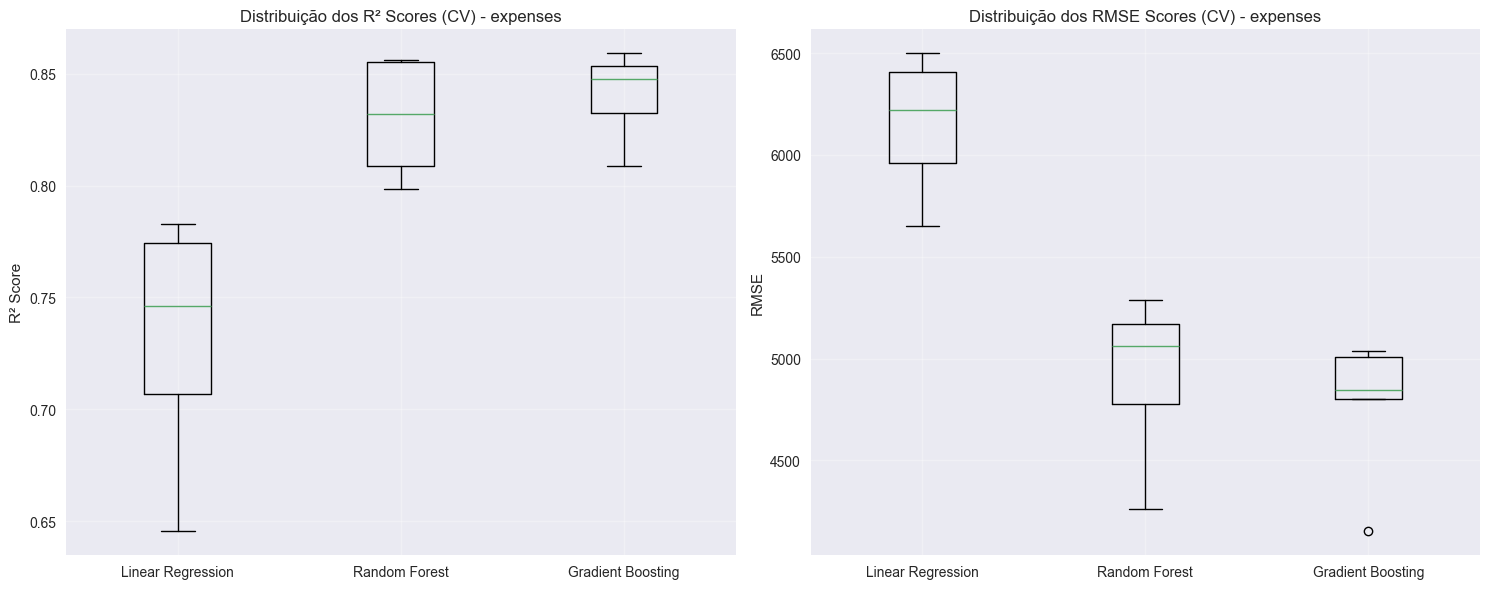

,Modelo,R² Médio,R² Desvio,RMSE Médio,RMSE Desvio
0,Linear Regression,0.7311,0.0504,6147.3849,308.1915
1,Random Forest,0.8301,0.0234,4911.6199,367.0319
2,Gradient Boosting,0.8403,0.0181,4768.5325,321.6383


,MAE,MSE,RMSE,R²,Modelo
0,4213.4945,3.402012e+07,5832.6767,0.7571,Linear Regression
1,2435.5833,1.927391e+07,4390.2061,0.8624,Random Forest
2,2370.0689,1.817423e+07,4263.1241,0.8703,Gradient Boosting


C:\Users\prado\AppData\Local\Temp\ipykernel_27048\3346909974.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(r2_data, labels=cv_results.keys())


Validação cruzada - log_expenses (métricas na escala original)


C:\Users\prado\AppData\Local\Temp\ipykernel_27048\3346909974.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(rmse_data, labels=cv_results.keys())


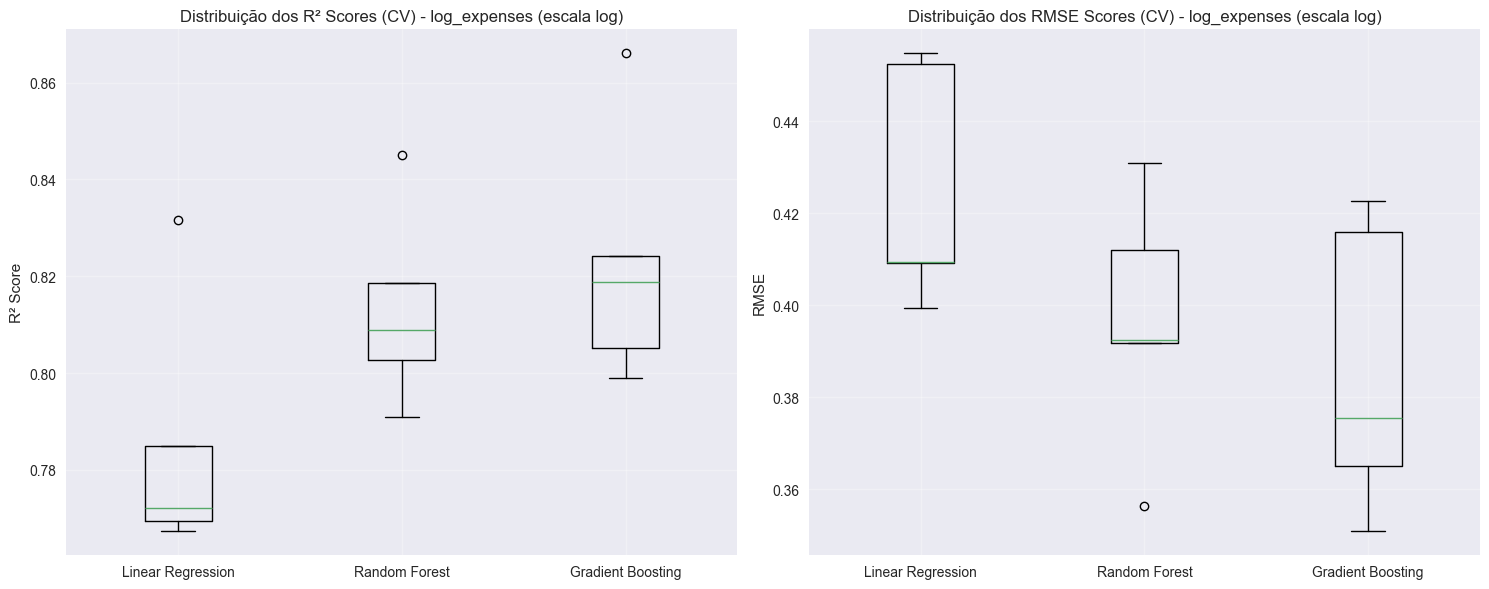

,Modelo,R² Médio,R² Desvio,RMSE Médio,RMSE Desvio
0,Linear Regression,0.7851,0.0241,0.4250,0.0236
1,Random Forest,0.8133,0.0183,0.3967,0.0248
2,Gradient Boosting,0.8227,0.0235,0.3860,0.0283


,MAE,MSE,RMSE,R²,Modelo
0,3781.1308,4.474108e+07,6688.8772,0.6806,Linear Regression
1,1961.2197,1.749141e+07,4182.2734,0.8751,Random Forest
2,2076.7011,1.827231e+07,4274.6123,0.8696,Gradient Boosting


In [6]:
# Plot de cross-validation
def plot_cv_results(cv_results, title_suffix):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    r2_data = [cv_results[name]['R2_scores'] for name in cv_results.keys()]
    rmse_data = [cv_results[name]['RMSE_scores'] for name in cv_results.keys()]
    ax1.boxplot(r2_data, labels=cv_results.keys())
    ax1.set_title(f'Distribuição dos R² Scores (CV) - {title_suffix}')
    ax1.set_ylabel('R² Score')
    ax1.grid(True, alpha=0.3)
    ax2.boxplot(rmse_data, labels=cv_results.keys())
    ax2.set_title(f'Distribuição dos RMSE Scores (CV) - {title_suffix}')
    ax2.set_ylabel('RMSE')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Expenses
print("Validação cruzada - expenses")
plot_cv_results(pipeline_expenses['cv_results'], 'expenses')
display(pipeline_expenses['cv_summary'].round(4))
display(pipeline_expenses['results_df'].round(4))

# Log_expenses (métricas já estão na escala original)
print("Validação cruzada - log_expenses (métricas na escala original)")
plot_cv_results(pipeline_log['cv_results'], 'log_expenses (escala log)')
display(pipeline_log['cv_summary'].round(4))
display(pipeline_log['results_df'].round(4))

## 5. Visualização das Métricas e Previsões

Visualização das métricas - expenses


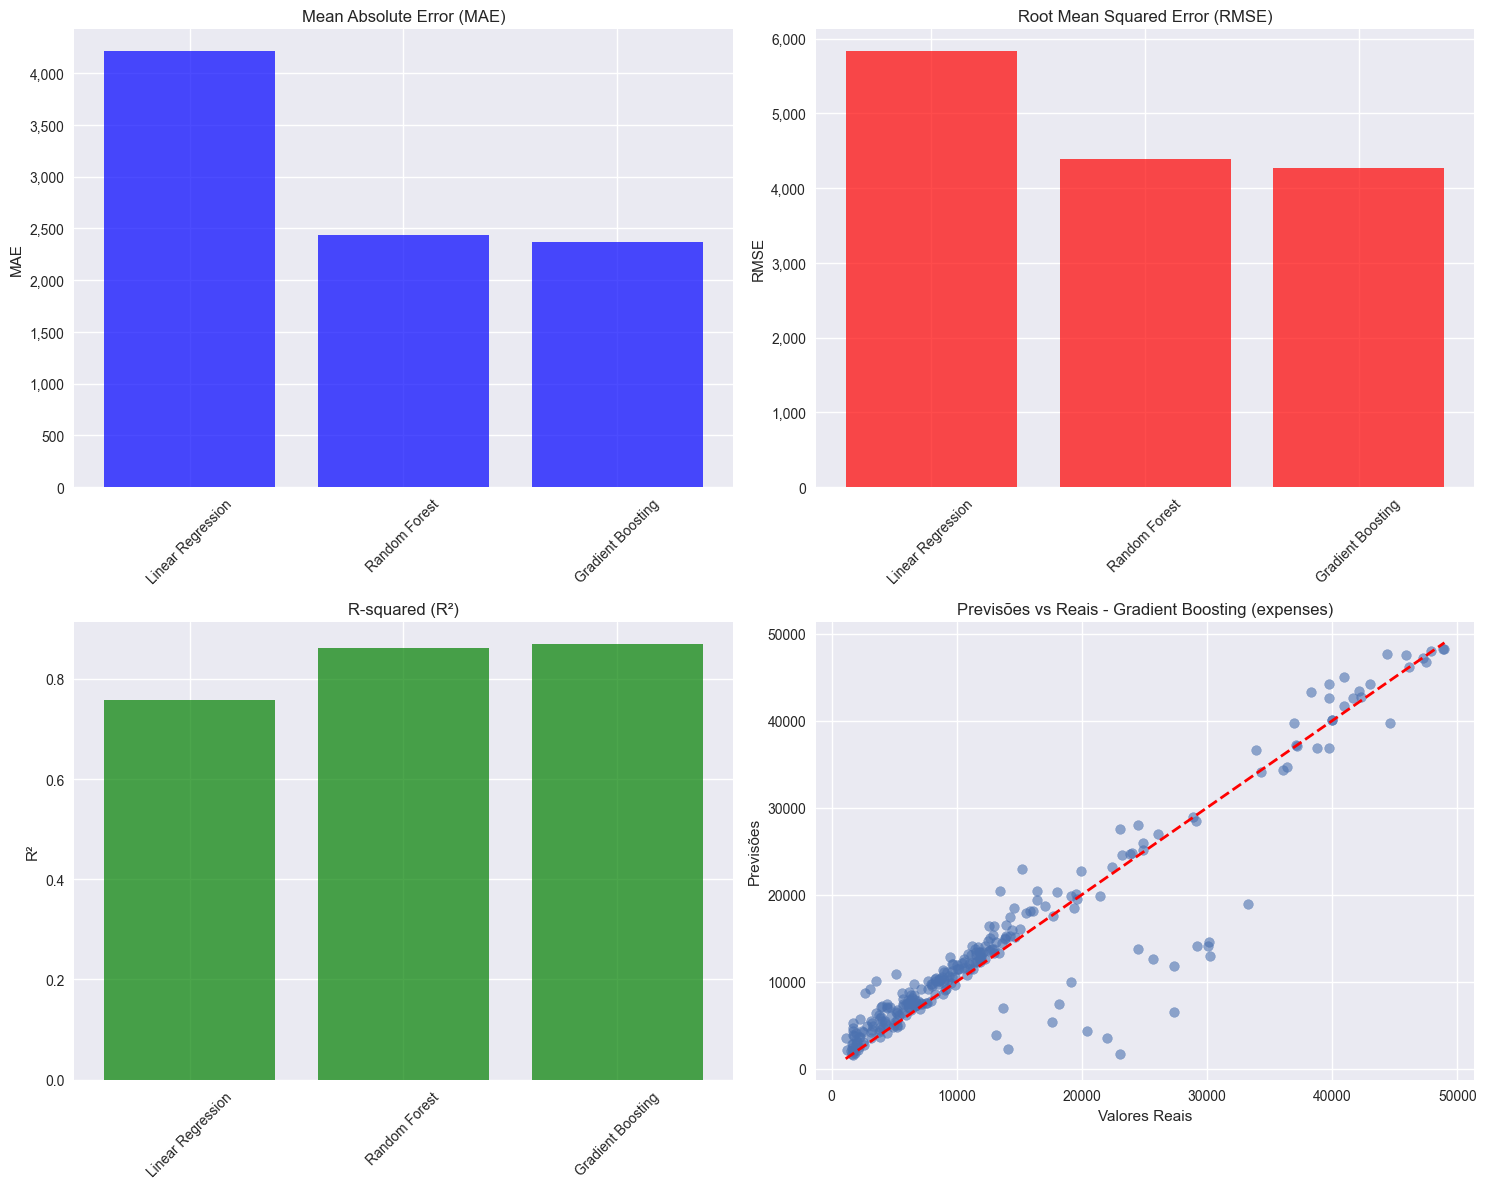


MELHOR MODELO (expenses): Gradient Boosting
R² Score: 0.8703
Visualização das métricas - log_expenses (métricas na escala original)


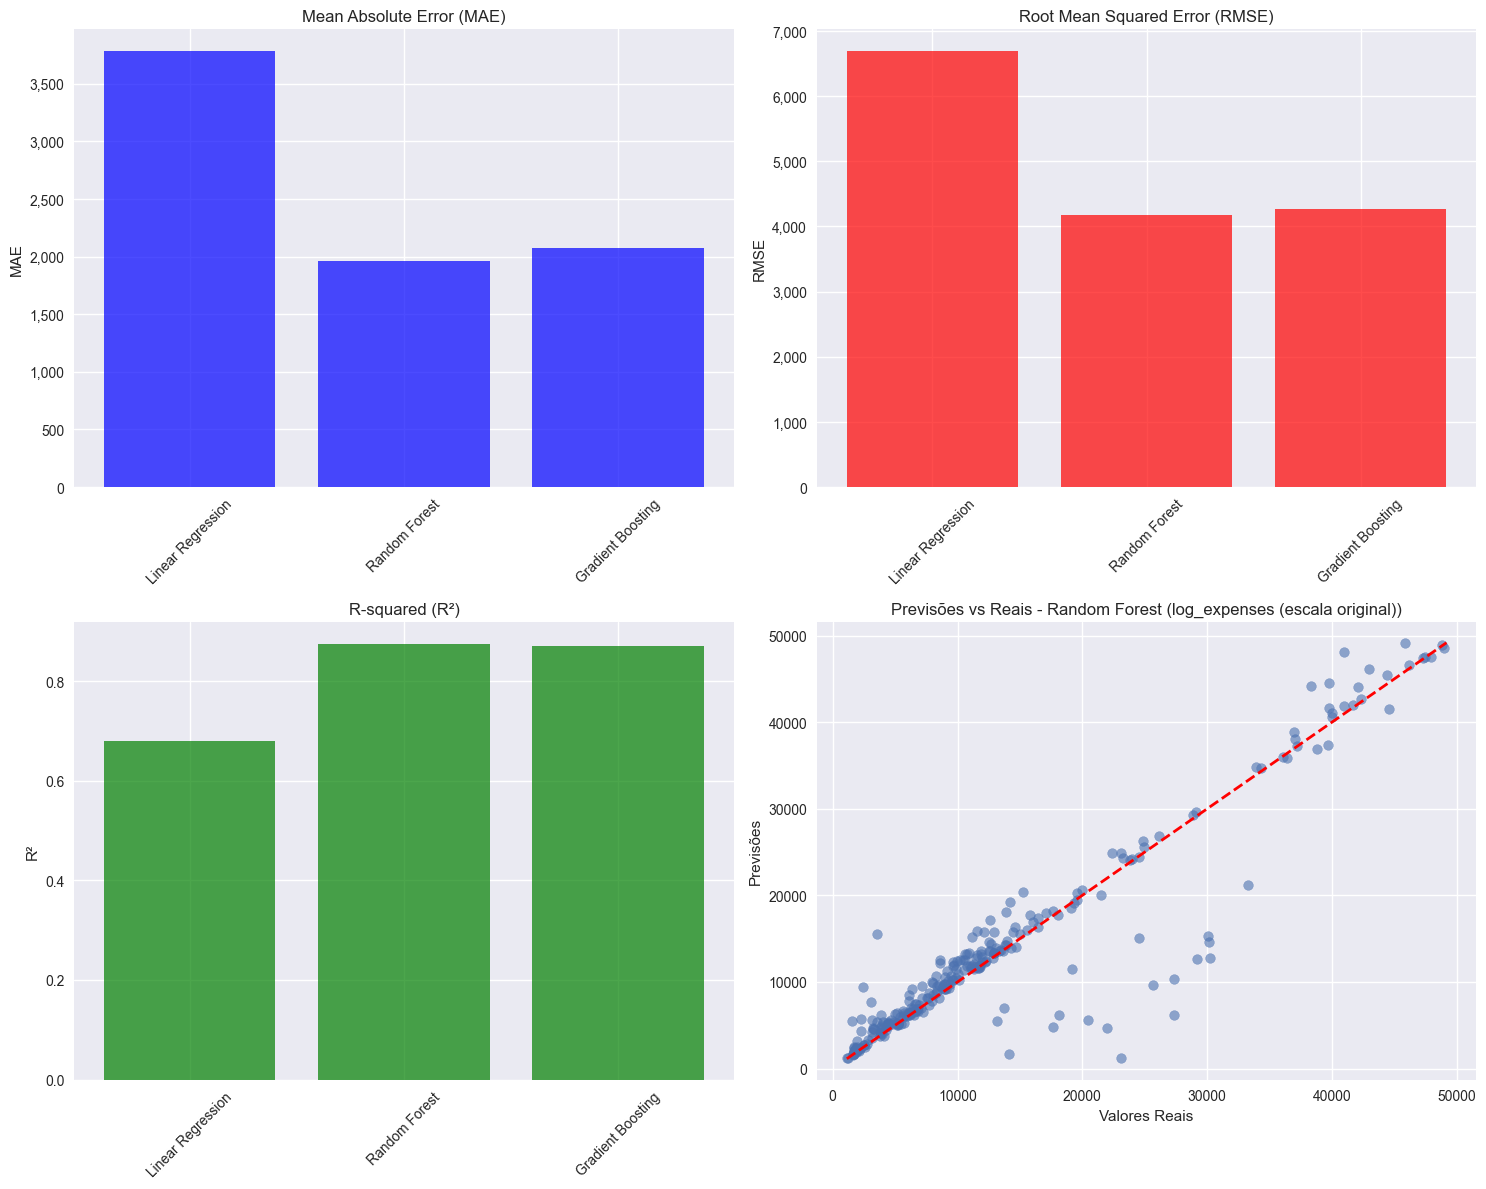


MELHOR MODELO (log_expenses (escala original)): Random Forest
R² Score: 0.8751


In [7]:
# Função das métricas e previsões
def plot_metrics_and_predictions(results_df, y_test, predictions, best_model_name, best_predictions, target_label, revert_log=False):
    import matplotlib.ticker as mticker
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    models_names = results_df['Modelo']

    # Se for log, converte para escala original
    if revert_log:
        y_test_plot = np.expm1(y_test)
        preds_plot = {k: np.expm1(v) for k, v in predictions.items()}
        best_pred_plot = np.expm1(best_predictions)
    else:
        y_test_plot = y_test
        preds_plot = predictions
        best_pred_plot = best_predictions

    # MAE
    ax1.bar(models_names, results_df['MAE'], color='blue', alpha=0.7)
    ax1.set_title('Mean Absolute Error (MAE)')
    ax1.set_ylabel('MAE')
    ax1.tick_params(axis='x', rotation=45)
    ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

    # RMSE
    ax2.bar(models_names, results_df['RMSE'], color='red', alpha=0.7)
    ax2.set_title('Root Mean Squared Error (RMSE)')
    ax2.set_ylabel('RMSE')
    ax2.tick_params(axis='x', rotation=45)
    ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

    # R²
    ax3.bar(models_names, results_df['R²'], color='green', alpha=0.7)
    ax3.set_title('R-squared (R²)')
    ax3.set_ylabel('R²')
    ax3.tick_params(axis='x', rotation=45)

    # melhor modelo
    ax4.scatter(y_test_plot, best_pred_plot, alpha=0.6)
    min_val = min(y_test_plot.min(), best_pred_plot.min())
    max_val = max(y_test_plot.max(), best_pred_plot.max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax4.set_xlabel('Valores Reais')
    ax4.set_ylabel('Previsões')
    ax4.set_title(f'Previsões vs Reais - {best_model_name} ({target_label})')

    plt.tight_layout()
    plt.show()

    print(f"\nMELHOR MODELO ({target_label}): {best_model_name}")
    print(f"R² Score: {results_df.loc[results_df['Modelo'] == best_model_name, 'R²'].values[0]:.4f}")

# Expenses
print("Visualização das métricas - expenses")
plot_metrics_and_predictions(
    pipeline_expenses['results_df'],
    pipeline_expenses['y_test'],
    pipeline_expenses['predictions'],
    pipeline_expenses['best_model_name'],
    pipeline_expenses['best_predictions'],
    target_label='expenses',
    revert_log=False
)

# Log_expenses (usa escala revertida)
print("Visualização das métricas - log_expenses (métricas na escala original)")
plot_metrics_and_predictions(
    pipeline_log['results_df'],
    pipeline_log['y_test'],
    pipeline_log['predictions'],
    pipeline_log['best_model_name'],
    pipeline_log['best_predictions'],
    target_label='log_expenses (escala original)',
    revert_log=True
)

## 6. Análise de Resíduos

Análise de resíduos - expenses


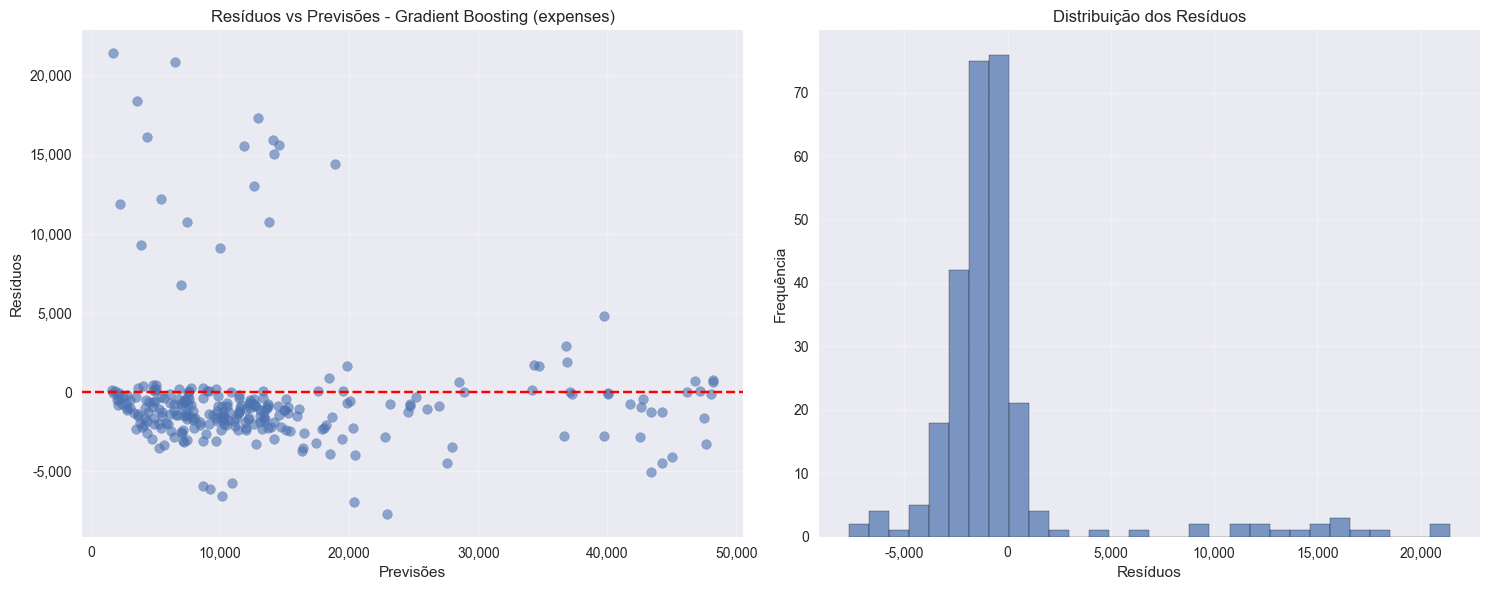


ESTATÍSTICAS DOS RESÍDUOS (Gradient Boosting - expenses):
Média: -305.971495
Desvio Padrão: 4260.0852
Mínimo: -7686.2904
Máximo: 21410.4607
Análise de resíduos - log_expenses (escala original)


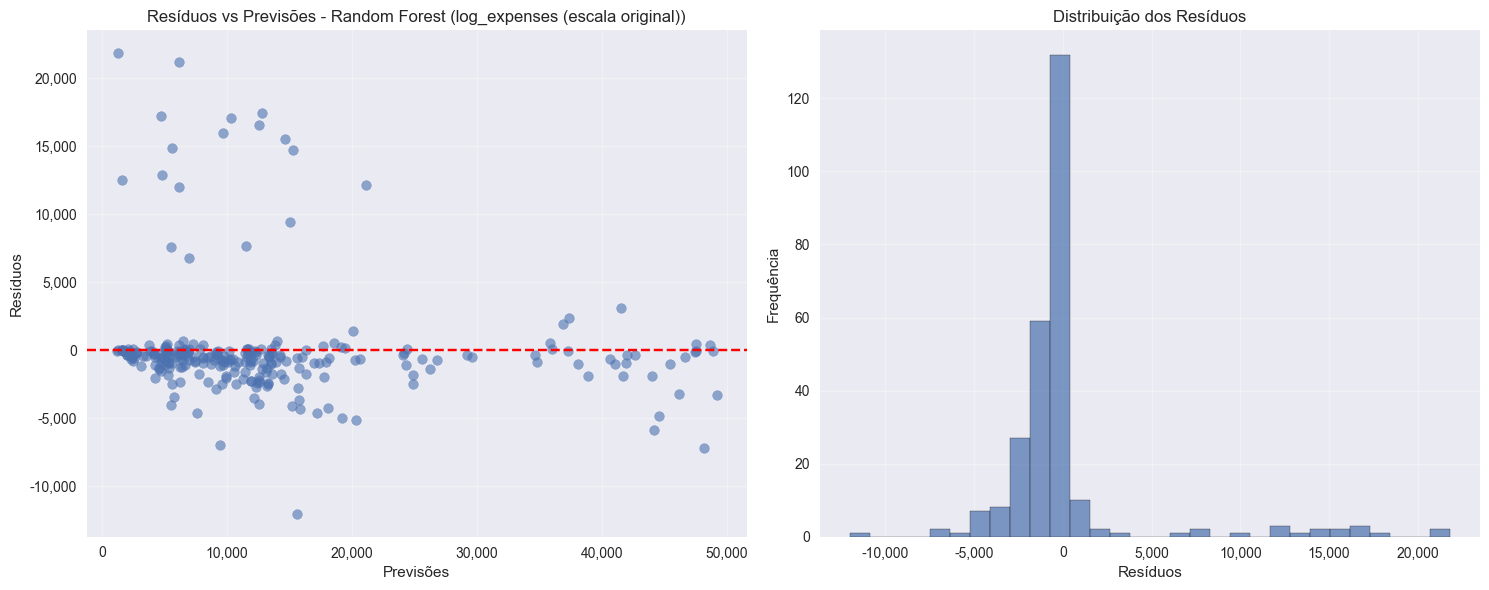


ESTATÍSTICAS DOS RESÍDUOS (Random Forest - log_expenses (escala original)):
Média: 57.816115
Desvio Padrão: 4189.6976
Mínimo: -12001.5881
Máximo: 21809.7466


In [8]:
# Função para análise de resíduos
def plot_residuals(y_test, best_predictions, residuals, best_model_name, target_label, revert_log=False):
    import matplotlib.ticker as mticker
    if revert_log:
        y_test_plot = np.expm1(y_test)
        best_pred_plot = np.expm1(best_predictions)
        residuals_plot = y_test_plot - best_pred_plot
    else:
        y_test_plot = y_test
        best_pred_plot = best_predictions
        residuals_plot = residuals

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    # Resíduos vs Previsões
    ax1.scatter(best_pred_plot, residuals_plot, alpha=0.6)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Previsões')
    ax1.set_ylabel('Resíduos')
    ax1.set_title(f'Resíduos vs Previsões - {best_model_name} ({target_label})')
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    ax1.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

    # Histograma dos resíduos
    ax2.hist(residuals_plot, bins=30, edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Resíduos')
    ax2.set_ylabel('Frequência')
    ax2.set_title('Distribuição dos Resíduos')
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

    plt.tight_layout()
    plt.show()

    # Estatísticas dos resíduos
    print(f"\nESTATÍSTICAS DOS RESÍDUOS ({best_model_name} - {target_label}):")
    print(f"Média: {residuals_plot.mean():.6f}")
    print(f"Desvio Padrão: {residuals_plot.std():.4f}")
    print(f"Mínimo: {residuals_plot.min():.4f}")
    print(f"Máximo: {residuals_plot.max():.4f}")

# Expenses
print("Análise de resíduos - expenses")
plot_residuals(
    pipeline_expenses['y_test'],
    pipeline_expenses['best_predictions'],
    pipeline_expenses['residuals'],
    pipeline_expenses['best_model_name'],
    'expenses',
    revert_log=False
)

# Log_expenses (usa escala revertida)
print("Análise de resíduos - log_expenses (escala original)")
plot_residuals(
    pipeline_log['y_test'],
    pipeline_log['best_predictions'],
    pipeline_log['residuals'],
    pipeline_log['best_model_name'],
    'log_expenses (escala original)',
    revert_log=True
)

## 7. Comparação Final das Métricas dos Modelos

Tabela comparativa das principais métricas (MAE, MSE, RMSE, R²) dos modelos para cada target.

In [9]:
# Adiciona coluna de target para comparação
df_exp = pipeline_expenses['results_df'].copy()
df_exp['Target'] = 'expenses'

df_log = pipeline_log['results_df'].copy()
df_log['Target'] = 'log_expenses (escala original)'

comparison_df = pd.concat([df_exp, df_log], ignore_index=True)

# Reorganiza colunas
cols = ['Target', 'Modelo', 'MAE', 'MSE', 'RMSE', 'R²']
comparison_df = comparison_df[cols]

print("Tabela comparativa das métricas dos modelos para cada target:")
display(comparison_df.round(4))

Tabela comparativa das métricas dos modelos para cada target:


,Target,Modelo,MAE,MSE,RMSE,R²
0,expenses,Linear Regression,4213.4945,3.402012e+07,5832.6767,0.7571
1,expenses,Random Forest,2435.5833,1.927391e+07,4390.2061,0.8624
2,expenses,Gradient Boosting,2370.0689,1.817423e+07,4263.1241,0.8703
3,log_expenses (escala original),Linear Regression,3781.1308,4.474108e+07,6688.8772,0.6806
4,log_expenses (escala original),Random Forest,1961.2197,1.749141e+07,4182.2734,0.8751
5,log_expenses (escala original),Gradient Boosting,2076.7011,1.827231e+07,4274.6123,0.8696
